<a href="https://colab.research.google.com/github/omanofx/portfolio/blob/main/vuelos_anac/vuelos_anac_arg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Omar Fernández

# The Project: Vuelos en Argentina entre 2019 y 2024

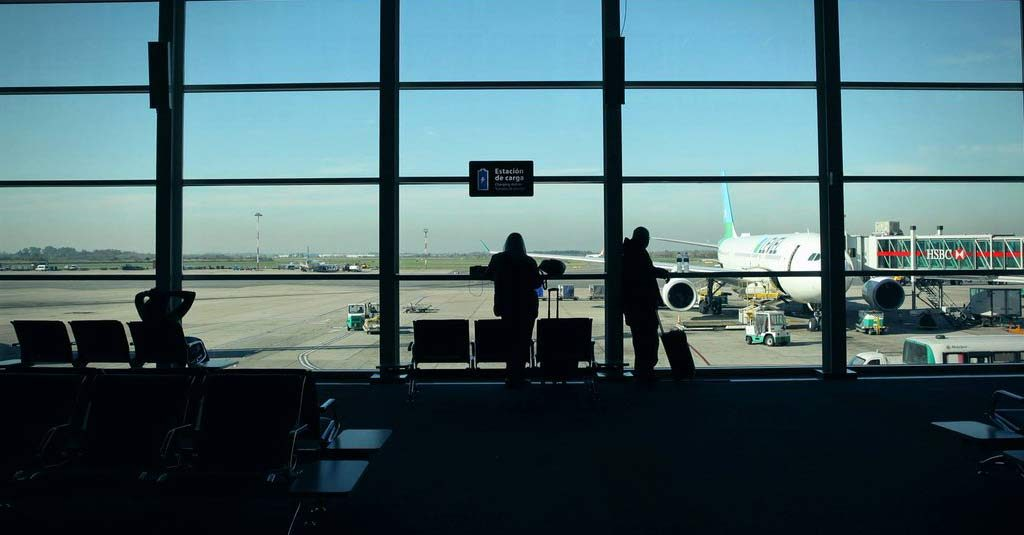

# Table of Contents

1. Executive Summary
1. Introduction
  1. Objective of the project
  1. Stakeholders
  1. Project Scope
  1. Assumptions and limitations
  1. Analysis to be performed
  1. Solution
1. Analytical context
  1. Requirements
  1. The Dataset
  1. Data set structure
  1. Data dimensions
  1. Libraries used
  1. Setting
  1. Functions
1. Data acquisition
  1. Backup
1. Data wrangling
  1. Main data set
  1. Target variable
  1. Feature Reduction
  1. Duplicate values
  1. NaN values
  1. Wrong values
  1. Transformation of data types
  1. Categorical variable labeling
  1. Feature engineering
  1. Outliers
  1. z-score method
  1. IQR method
  1. Secondary data set (optional)
  1. Save files
1. Exploratory Data Analysis (EDA)
  1. EDA Conclusions
1. Feature Selection
  1. Correlation matrix
  1. Stepwise
1. Model training
  1. Split the dataframe
1. Massive model training
  1. Models: Configuration
  1. Comparison
  1. ROC Raven
  1. Bias and Variance
1. Final project results
1. Conclusions and final recommendations
1. References
1. Change log

# Analytical context

### Data set structure

**Fecha**:
	Fecha ISO-8601 (date)
	Fecha de vuelo UTC

**Hora UTC**:
	Tiempo ISO-8601 (time)
	Hora UTC (Tiempo Universal Coordinado) . Al evaluar el dato, considerar que Argentina tiene hora oficial UTC -3.  

**Clase de Vuelo (todos los vuelos)**:
	Texto (string)
	Categorías de vuelos

**Clasificación Vuelo**:
	Texto (string)
	Clasificación del tipo de vuelo: Cabotaje o Internacional  

**Tipo de Movimiento**:
	Texto (string)
	Clasificación del tipo de movimiento. Se considera “Movimiento” a una operación, sea aterrizaje o despegue.

**Aeropuerto**:
	Texto (string)
	Nombre del aeropuerto código FAA  

**Origen/Destino**:
	Texto (string)
	Se utiliza el código FAA para aeropuertos nacionales y OACI para aeropuertos extranjeros.  

**Aerolínea Nombre**:
	Texto (string)
	Nombre de la línea aérea  

**Aeronave**:
	Texto (string)
	Código para identificar a los fabricantes de la aeronaves con la designación específica del modelo del avión.

**Pasajeros**:
	Número entero (integer)
	Cantidad de pasajeros operación individual (despegue/aterrizaje). Para vuelos de cabotaje se registra despegue y aterrizaje. Al analizar un Aeropuerto individual se debe tomar el dato de esta columna

**PAX**:
	Número entero (integer)
	1pax=1tarjeta de embarque. Usar esta columna al analizar la cantidad de pasajeros cabotaje a nivel total país. Al analizar los pasajeros internacionales es indiferente usar esta columna o la anterior.

**Calidad dato**:
	Texto (string)
	La información de los últimos 3 meses es provisoria  

### Libraries used

In [1]:
# Visualización de datos
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Otros
import datetime
from datetime import datetime, timedelta

# Configura la zona horaria local
import pytz

# Configuración adicional
%matplotlib inline

# Import warnings module
import warnings
warnings.filterwarnings('ignore')

### Setting

In [2]:
# Configura la zona horaria local
time_zone = pytz.timezone('America/Argentina/Buenos_Aires')
formato_fecha_hora = '%Y-%m-%d %H:%M:%S'

### Functions

In [3]:
def fecha_hora_local(local_timezone: pytz.timezone = pytz.timezone('America/Argentina/Buenos_Aires')):
    '''
    Esta función muestra la fecha y hora local cada vez que es invocada.
    :param local_timezone: La zona horaria local deseada (por defecto, 'America/Argentina/Buenos_Aires').
    :return: La fecha y hora local en el formato especificado.
    '''
    try:
        # Obtiene la hora local actual en UTC
        utc_now = datetime.utcnow()

        # Convierte la hora actual a la hora local
        local_time = utc_now.replace(tzinfo=pytz.utc).astimezone(local_timezone)

        # Formato de salida para la fecha y hora local
        formato_fecha_hora = "%Y-%m-%d %H:%M:%S"

        # Retorna la fecha y hora local formateada
        return local_time.strftime(formato_fecha_hora)

    except Exception as e:
        # En caso de error, imprime el error y retorna None
        print("Error al obtener la fecha y hora local:", str(e))
        return None

In [4]:
def tiene_espacios_en_blanco(columna: str) -> bool:
    '''
    Verifica si una columna contiene espacios en blanco.
    :param columna: La columna a ser verificada (str).
    :return: True si la columna contiene al menos un espacio en blanco, False de lo contrario.
    '''
    try:
        # Utiliza una expresión generadora y la función any para verificar si
        # alguno de los caracteres es un espacio en blanco
        return any(caracter.isspace() for caracter in columna)

    except Exception as e:
        # En caso de error, imprime el error y retorna False
        print("Error al verificar espacios en blanco en la columna:", str(e))
        return False

In [5]:
def analizar_dataframe(df1: pd.DataFrame, porcentaje_tolerancia: float):
    '''
    ## Esta función se utiliza para comprobar la consistencia de los datos de un DataFrame
    ### evita invocar a .info(), .isnull()
    #### Porcentaje de tolerancia: valor porcentual que se tolera para los valores nulos de
    #### cada caracteristica del DataFrame. Si el valor se encuentra por sobre la tolerancia,
    #### se indica como 'BORRAR' la caracteristica.
    #### Version 2.0
    '''
    # Validar que porcentaje_tolerancia esté entre 0 y 100
    if not (0 <= porcentaje_tolerancia <= 100):
        print("Error: El porcentaje de tolerancia debe estar entre 0 y 100.")
        return

    porcentaje_perdidos = df1.isnull().sum() * 100 / len(df1)
    total_nulos = df1.isnull().sum()
    tipo_dato = df1.dtypes
    valores_no_nulos_por_columna = df1.count()
    descripcion = df1.describe().transpose()
    es_categorica = [True if tipo == 'object' else False for tipo in tipo_dato]
    total_ceros_por_columna = [(columna, (df1[columna] == 0).sum()) for columna in df1.columns]

    resultado_analisis = pd.DataFrame({
        'Tipo de dato': tipo_dato,
        'Total No Nulos': valores_no_nulos_por_columna,
        'Total Nulos': total_nulos,
        '% Nulos': round(porcentaje_perdidos, 2),
        'Borrar?': np.where(porcentaje_perdidos > porcentaje_tolerancia, 'BORRAR', ''),
        'Total Ceros': [total for columna, total in total_ceros_por_columna],
        'Columna con Espacios': df1.columns.to_series().apply(lambda x: tiene_espacios_en_blanco(x))
    })

    # Agregar las columnas de la descripción al resultado_analisis
    resultado_analisis = pd.concat([resultado_analisis, round(descripcion, 2)], axis=1)

    estilo_resultado = (
        resultado_analisis.style
        .applymap(lambda x: 'background-color: green' if x == 'object' else '',
                  subset=['Tipo de dato'])
        .applymap(lambda x: 'background-color: red' if x > porcentaje_tolerancia else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['% Nulos'] > porcentaje_tolerancia].index, '% Nulos'])
        .background_gradient(cmap='Reds', subset=['% Nulos'])
        .applymap(lambda x: 'background-color: red' if x else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['Columna con Espacios']].index, 'Columna con Espacios'])
        .background_gradient(cmap='Reds', subset=['Columna con Espacios'])
    )

    return estilo_resultado

In [6]:
def grabar_csv(nombre_archivo: str, df: pd.DataFrame):
    '''
    Almacena físicamente los datos obtenidos en un archivo CSV.
    :param nombre_archivo: El nombre base del archivo CSV.
    :param df: El DataFrame que se desea guardar en el archivo CSV.
    '''
    try:
        # Obtiene la fecha y hora actual para agregarla al nombre del archivo
        fecha_y_hora_actual = fecha_hora_local(time_zone)

        # Especifica la ruta y el nombre del archivo CSV
        ruta_archivo_csv = f"{nombre_archivo}_{fecha_y_hora_actual}.csv"

        # Guarda el DataFrame en un archivo CSV sin incluir el índice
        df.to_csv(ruta_archivo_csv, index=False)

        # Imprime la fecha y hora de guardado y la ruta del archivo
        print("Fecha y hora:", fecha_y_hora_actual)
        print(f"Los datos se han guardado en el archivo CSV: {ruta_archivo_csv}")

    except Exception as error:
        # Maneja cualquier error que pueda ocurrir durante el proceso de guardado
        print(f"Ocurrió un error al guardar los datos en el archivo CSV: {error}")

In [7]:
def validar_rango_datos(df, column_name, min_value, max_value):
    """
    Función para verificar si hay valores fuera de un rango especificado en una columna de un DataFrame.

    Parámetros:
    - df: DataFrame de pandas.
    - column_name: Nombre de la columna que se va a verificar.
    - min_value: Valor mínimo permitido en la columna.
    - max_value: Valor máximo permitido en la columna.

    Retorna:
    - filtered_values: DataFrame que contiene las filas con valores fuera del rango especificado.
    """
    # Filtrar los valores que están fuera del rango especificado
    filtered_values = df[(df[column_name] < min_value) | (df[column_name] > max_value)]

    # Verificar si no hay errores
    if filtered_values.empty:
        print('Esta característica no presenta errores')
        return None
    else:
        print('Se detectaron errores:')
        return filtered_values

In [8]:
def calcular_porcentage(df: pd.DataFrame, column_name: str):
    """
    Calcula el porcentaje de cada valor único en una columna de un DataFrame.

    Parámetros:
    df (pandas.DataFrame): El DataFrame que contiene los datos.
    column_name (str): El nombre de la columna para la cual se calcularán los porcentajes.

    Retorna:
    pandas.Series: Una serie que contiene los porcentajes de cada valor único en la columna.
    """
    # Verificar si la columna existe en el DataFrame
    if column_name not in df.columns:
        print(f"La columna '{column_name}' no existe en el DataFrame.")
        return None

    # Obtener recuentos de valores únicos en la columna
    value_counts = df[column_name].value_counts()

    # Calcular los porcentajes
    percentages = (value_counts / len(df[column_name])) * 100

    # Asignar un nombre al índice para mayor claridad
    percentages = percentages.rename_axis(column_name)

    return percentages

# Data acquisition

In [9]:
# Lista de atributos para la obtención de cada dataset por año
url_files = [
    {
        "year": 2019,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/aa8337de-3565-4ecf-9cd9-6f1c61f8f0ed/download/2019_informe_ministerio.csv",
        "separator": ";"
    },
    {
        "year": 2020,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/d0e75e7d-e416-470f-bedb-ef2a877cbae3/download/2020_informe_ministerio.csv",
        "separator": ";"

    },
    {
        "year": 2021,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/1b4f569a-cab0-4560-993c-5bf96c3e7cf0/download/202112_informe_ministerio.csv",
        "separator": ","
    },
    {
        "year": 2022,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/11894a35-de36-4579-b084-d1191f551fbe/download/202212-informe-ministerio.csv",
        "separator": ";"
    },
    {
        "year": 2023,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/e910fead-ade3-40ce-ae8f-cad2017aa007/download/202312-informe-ministerio-actualizado-dic.csv",
        "separator": ";"
    },
    {
        "year": 2024,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/6004191c-83ca-4a0a-a687-c059bb0a8c8e/download/202403-informe-ministerio.csv",
        "separator": ";"
    }
]

In [10]:
# Version 2
try:
    # Lista para almacenar los DataFrames procesados
    list_of_df = []

    columns_names = ['Fecha', 'Hora UTC', 'Clase de vuelos (todos los vuelos)', 'Clasificacion Vuelo',
                     'Tipo Movimiento', 'Aeropuerto', 'Origen/Destino',
                     'Aerolinea Nombre', 'Aeronave', 'Pasajeros', 'PAX', 'Calidad del dato']

    print(" --- Loop Start --- \n")
    # leer cada item de la lista url_files
    for file in url_files:
        #print(file["year"], file["url"], file["separator"])

        print("Processing year: " + str(file["year"]), " - News found")
        print(50 * "-")
        # Leer el archivo CSV desde la URL
        df_temp = pd.read_csv(file["url"], sep = file["separator"], header = 1)

        # Añadir el nombre de las columnas al DataFrame
        df_temp.columns = columns_names

        # Añadir el DataFrame a la lista
        list_of_df.append(df_temp)

        # Imprimir el año y el número de filas en el DataFrame
        print(f" Year:", str(file["year"]), "Number of rows: " ,len(df_temp))
        print(" CSV file has been uploaded successfully.\n")

        print(f"End of file\n")

    # Concatenar todos los DataFrames en la lista
    df_vuelos_raw = pd.concat(list_of_df, ignore_index=True)

except Exception as e:
    print("An error occurred while uploading the CSV file:", e)


 --- Loop Start --- 

Processing year: 2019  - News found
--------------------------------------------------
 Year: 2019 Number of rows:  580773
 CSV file has been uploaded successfully.

End of file

Processing year: 2020  - News found
--------------------------------------------------
 Year: 2020 Number of rows:  212725
 CSV file has been uploaded successfully.

End of file

Processing year: 2021  - News found
--------------------------------------------------
 Year: 2021 Number of rows:  328135
 CSV file has been uploaded successfully.

End of file

Processing year: 2022  - News found
--------------------------------------------------
 Year: 2022 Number of rows:  477084
 CSV file has been uploaded successfully.

End of file

Processing year: 2023  - News found
--------------------------------------------------
 Year: 2023 Number of rows:  557151
 CSV file has been uploaded successfully.

End of file

Processing year: 2024  - News found
-----------------------------------------------

In [11]:
df_vuelos_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300855 entries, 0 to 2300854
Data columns (total 12 columns):
 #   Column                              Dtype 
---  ------                              ----- 
 0   Fecha                               object
 1   Hora UTC                            object
 2   Clase de vuelos (todos los vuelos)  object
 3   Clasificacion Vuelo                 object
 4   Tipo Movimiento                     object
 5   Aeropuerto                          object
 6   Origen/Destino                      object
 7   Aerolinea Nombre                    object
 8   Aeronave                            object
 9   Pasajeros                           int64 
 10  PAX                                 object
 11  Calidad del dato                    object
dtypes: int64(1), object(11)
memory usage: 210.6+ MB


In [12]:
df_vuelos_raw

,Fecha,Hora UTC,Clase de vuelos (todos los vuelos),Clasificacion Vuelo,Tipo Movimiento,Aeropuerto,Origen/Destino,Aerolinea Nombre,Aeronave,Pasajeros,PAX,Calidad del dato
0,1/1/2019,00:01:00,REGULAR,Internacional,Aterrizaje,EZE,SBGL,TRANSPORTES AEREOS DEL MERCOSUR,NaN,165,165,DEFINITIVO
1,1/1/2019,00:03:00,REGULAR,Doméstico,Aterrizaje,AER,SIS,AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A,EMB-ERJ190100IGW,22,11,DEFINITIVO
2,1/1/2019,00:04:00,REGULAR,Internacional,Aterrizaje,EZE,SBGR,TRANSPORTES AEREOS DEL MERCOSUR,NaN,69,69,DEFINITIVO
3,1/1/2019,00:06:00,REGULAR,Internacional,Aterrizaje,AER,SBGR,LAN ARGENTINA S.A. (LATAM AIRLINES),AIB-A-320-233,53,53,DEFINITIVO
4,1/1/2019,00:09:00,REGULAR,Doméstico,Despegue,TUC,AER,LAN ARGENTINA S.A. (LATAM AIRLINES),AIB-A-320-233,156,78,DEFINITIVO
...,...,...,...,...,...,...,...,...,...,...,...,...
2300850,31/03/2024,22:25,Regular,Doméstico,Despegue,IGU,AER,AEROLINEAS ARGENTINAS SA,BO-737-800,115,58,PROVISORIO
2300851,31/03/2024,23:42,Regular,Doméstico,Despegue,IGU,SIS,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,0,0,PROVISORIO
2300852,31/03/2024,19:03,Regular,Doméstico,Aterrizaje,LAR,AER,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,74,37,PROVISORIO
2300853,31/03/2024,22:42,Regular,Doméstico,Despegue,LAR,AER,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,70,35,PROVISORIO


In [13]:
analizar_dataframe(df_vuelos_raw, 100)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,std,min,25%,50%,75%,max
Fecha,object,2300855,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
Hora UTC,object,2300855,0,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Clase de vuelos (todos los vuelos),object,2300855,0,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Clasificacion Vuelo,object,2300855,0,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Tipo Movimiento,object,2300852,3,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Aeropuerto,object,2300855,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
Origen/Destino,object,2300852,3,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
Aerolinea Nombre,object,2118448,182407,7.930000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Aeronave,object,2209194,91661,3.980000,,131072,False,nan,nan,nan,nan,nan,nan,nan,nan
Pasajeros,int64,2300855,0,0.000000,,832706,False,2300855.000000,85.610000,95.210000,0.000000,0.000000,68.000000,158.000000,1626.000000


# Data wrangling

In [179]:
# Copia para procesar los datos obtenidos.
df_vuelos = df_vuelos_raw.copy()

In [180]:
# Renombrar características
df_vuelos.rename(columns={'Fecha': 'date',
                          'Hora UTC': 'time_utc',
                          'Aeropuerto': 'airport',
                          'Clasificacion Vuelo': 'international_flight',
                          'Clase de vuelos (todos los vuelos)': 'fly_type',
                          'Tipo Movimiento': 'type_movement',
                          'Origen/Destino': 'origin_destination',
                          'Aerolinea Nombre': 'airline_name',
                          'Aeronave': 'aircraft',
                          'Pasajeros': 'passengers',
                          'PAX': 'pax',
                          'Calidad del dato': 'data_quality'}, inplace=True)

In [196]:
df_vuelos.sample(10)

,date,time_utc,fly_type,international_flight,type_movement,airport,origin_destination,airline_name,aircraft,passengers,pax,data_quality
1530229,2022-11-09,1900-01-01 17:37:00,Vuelo de Adiestramiento,False,Despegue,GRA,GRA,0,PAA-PA-A-28-181,0,0,PROVISORIO
89195,2019-02-23,1900-01-01 20:32:00,REGULAR,False,Despegue,CRV,AER,AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A,EMB-ERJ190100IGW,172,86,DEFINITIVO
202374,2019-05-04,1900-01-01 16:00:00,VUELOS ESCUELA,False,Aterrizaje,MOR,MOR,NaN,CE-150-G,0,0,DEFINITIVO
1576046,2022-12-14,1900-01-01 21:06:00,No Regular,False,Despegue,GAL,HCV,0,LPA-A 109 E,0,0,PROVISORIO
724405,2020-08-03,1900-01-01 18:56:00,Vuelo Privado con Matrícula Nacional,False,Despegue,TUC,TUC,0,0,0,0,DEFINITIVO
151074,2019-04-01,1900-01-01 21:49:00,VUELOS ESCUELA,False,Aterrizaje,ROS,ROS,NaN,CE-150-M,0,0,DEFINITIVO
543590,2019-12-06,1900-01-01 22:20:00,REGULAR,True,Aterrizaje,DOZ,SCEL,SKY AIRLINE S.A.,NaN,139,139,DEFINITIVO
1858383,2023-06-19,1900-01-01 07:20:00,Regular,True,Aterrizaje,EZE,MPTO,DHL,0,0,0,DEFINITIVO
926373,2021-06-23,1900-01-01 18:28:00,Vuelo Privado con Matrícula Nacional,False,Aterrizaje,FDO,CTP,0,BE-200,2,1,DEFINITIVO
177474,2019-04-17,1900-01-01 20:35:00,REGULAR,False,Despegue,SVO,AER,AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A,EMB-ERJ190100IGW,160,80,DEFINITIVO


## Duplicate values

In [ ]:
total_duplicados = df_vuelos.duplicated().sum()

if total_duplicados > 0:
    print("En total de observaciones duplicadas en el DataFrame:", total_duplicados)
    df_vuelos.drop_duplicates(inplace=True)
    print("Se eliminaron las observaciones duplicadas.")
else:
    print("El DataFrame no tiene observaciones duplicadas.")

## Transformation of data types

In [182]:
# borrar

df_backup = df_vuelos.copy()

In [178]:
#borrar

df_vuelos = df_backup.copy()

In [183]:
# Convert the 'date' column to datetime format using ISO-8601
df_vuelos['date'] = pd.to_datetime(df_vuelos['date'], format="%d/%m/%Y")

In [184]:
# Busca el tamaño de los tipos de formatos de fechas existentes
df_vuelos['time_utc'].str.len().unique()

array([8, 5, 4])

In [185]:
# Aplicar lambda cuando la longitud de 'time_utc' sea 8, y eliminar ':00' del final
df_vuelos['time_utc'] = df_vuelos['time_utc'].apply(lambda x: x[:-3] if len(x) == 8 and x.endswith(':00') else x)

In [186]:
# Convert the 'time_utc' column to datetime format using ISO-8601
df_vuelos['time_utc'] = pd.to_datetime(df_vuelos['time_utc'], format="%H:%M")

In [191]:
df_vuelos['international_flight'].unique()

array(['Internacional', 'Doméstico', 'Dom', 'Inter'], dtype=object)

In [192]:
# Si el vuelo es Internacional = 1
df_vuelos['international_flight'].replace('Internacional', 1, inplace=True)
df_vuelos['international_flight'].replace('Inter', 1, inplace=True)
# Si es Domestico = 0
df_vuelos['international_flight'].replace('Dom', 0, inplace=True)
df_vuelos['international_flight'].replace('Doméstico', 0, inplace=True)

In [193]:
# Ahora transforma la característica en booleana
df_vuelos['international_flight'] = df_vuelos['international_flight'].astype(bool)

In [194]:
analizar_dataframe(df_vuelos, 100)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,min,25%,50%,75%,max,std
date,datetime64[ns],2300855,0,0.000000,,0,False,2300855,2021-10-03 15:21:15.376847872,2019-01-01 00:00:00,2019-12-27 00:00:00,2022-01-30 00:00:00,2023-03-26 00:00:00,2024-03-31 00:00:00,nan
time_utc,datetime64[ns],2300855,0,0.000000,,0,False,2300855,1900-01-01 14:49:24.591405824,1900-01-01 00:00:00,1900-01-01 11:59:00,1900-01-01 15:34:00,1900-01-01 19:27:00,1900-01-01 23:59:00,nan
fly_type,object,2300855,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
international_flight,bool,2300855,0,0.000000,,1915613,False,nan,nan,nan,nan,nan,nan,nan,nan
type_movement,object,2300852,3,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
airport,object,2300855,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
origin_destination,object,2300852,3,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
airline_name,object,2118448,182407,7.930000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
aircraft,object,2209194,91661,3.980000,,131072,False,nan,nan,nan,nan,nan,nan,nan,nan
passengers,int64,2300855,0,0.000000,,832706,False,2300855.000000,85.606400,0.000000,0.000000,68.000000,158.000000,1626.000000,95.214181


In [189]:
df_vuelos['time_utc'].value_counts()

time_utc
1900-01-01 15:00:00    3805
1900-01-01 14:00:00    3702
1900-01-01 13:00:00    3641
1900-01-01 16:00:00    3621
1900-01-01 14:30:00    3441
                       ... 
1900-01-01 05:54:00     197
1900-01-01 06:39:00     194
1900-01-01 06:29:00     192
1900-01-01 06:34:00     188
1900-01-01 06:31:00     187
Name: count, Length: 1440, dtype: int64

In [190]:
df_vuelos['airport'].unique()

array(['EZE', 'AER', 'TUC', 'MDP', 'DOZ', 'CBA', 'IGU', 'PAL', 'FDO',
       'ROS', 'BAR', 'SAL', 'NEU', 'ECA', 'GRA', 'SVO', 'JUJ', 'TRC',
       'GAL', 'POS', 'STR', 'OSA', 'USU', 'BCA', 'TRE', 'SIS', 'FSA',
       'SRA', 'VIE', 'CRV', 'CAT', 'ESQ', 'CHP', 'RTA', 'DRY', 'PAR',
       'JUA', 'CRR', 'SDE', 'MOR', 'UIS', 'LAR', 'MLG', 'DIL', 'BAL',
       'RYD', 'DIA', 'TRH', 'GOY', 'GPI', 'PTA', 'MDB', 'ARS', 'DOL',
       'HDO', 'NIN', 'EAU', 'RIN', 'CUT'], dtype=object)

In [214]:
import re  # Importar el módulo re para trabajar con expresiones regulares

palabras_a_eliminar = ['VUELOS', 'vuelo', 'vuelo de', 'Vuelo de', 'Vuelo']

# Generar una expresión regular con las palabras a eliminar
regex = '|'.join(map(re.escape, palabras_a_eliminar))

# Aplicar la expresión regular para eliminar las palabras de la columna 'fly_type'
df_vuelos['fly_type'] = df_vuelos['fly_type'].str.replace(regex, '')


In [215]:
df_vuelos['fly_type'].unique()

array(['REGULAR', 'PRIVADOS NACIONALES', 'OFICIALES NACIONALES',
       'NO REGULAR', 'PRIVADO CON MATRICULA EXTRANJERA', 'TRABAJO AEREO',
       'DE ADIESTRAMIENTO', 'ESCUELA', 'OFICIALES EXTRANJEROS',
       'ESCUELA (NO VIGENTE)', 'Regular',
       'Vuelo Privado con Matrícula Nacional', 'No Regular',
       'Vuelo Privado con Matrícula Extranjera', 'Trabajo Aéreo',
       'Vuelo de Adiestramiento', 'Vuelo Oficial Extranjero',
       'Vuelo Oficial Nacional', 'Vuelo Escuela'], dtype=object)

In [221]:
df_vuelos.query("type_movement== 'Despegue'")

,date,time_utc,fly_type,international_flight,type_movement,airport,origin_destination,airline_name,aircraft,passengers,pax,data_quality
4,2019-01-01,1900-01-01 00:09:00,REGULAR,False,Despegue,TUC,AER,LAN ARGENTINA S.A. (LATAM AIRLINES),AIB-A-320-233,156,78,DEFINITIVO
5,2019-01-01,1900-01-01 00:11:00,REGULAR,False,Despegue,MDP,AER,AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A,EMB-ERJ190100IGW,4,2,DEFINITIVO
7,2019-01-01,1900-01-01 00:13:00,REGULAR,True,Despegue,EZE,KDFW,AMERICAN AIRLINES INC.,NaN,272,272,DEFINITIVO
8,2019-01-01,1900-01-01 00:14:00,REGULAR,False,Despegue,AER,CBA,LAN ARGENTINA S.A. (LATAM AIRLINES),AIB-A-320-233,100,50,DEFINITIVO
9,2019-01-01,1900-01-01 00:15:00,REGULAR,True,Despegue,EZE,SBGR,ETHIOPIAN AIRLINES,NaN,163,163,DEFINITIVO
...,...,...,...,...,...,...,...,...,...,...,...,...
2300849,2024-03-31,1900-01-01 21:30:00,Regular,False,Despegue,IGU,AER,AEROLINEAS ARGENTINAS SA,BO-737-8,164,82,PROVISORIO
2300850,2024-03-31,1900-01-01 22:25:00,Regular,False,Despegue,IGU,AER,AEROLINEAS ARGENTINAS SA,BO-737-800,115,58,PROVISORIO
2300851,2024-03-31,1900-01-01 23:42:00,Regular,False,Despegue,IGU,SIS,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,0,0,PROVISORIO
2300853,2024-03-31,1900-01-01 22:42:00,Regular,False,Despegue,LAR,AER,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,70,35,PROVISORIO


## NaN values

In [233]:
df_vuelos['type_movement'].unique()

array(['Aterrizaje', 'Despegue'], dtype=object)

In [232]:
# Elimina los registros con type movement en NaN
df_vuelos = df_vuelos.dropna(subset=['type_movement'])

In [162]:
# Reemplaza los valores NaN
df_vuelos['airline_name'].fillna('unknown', inplace=True)

df_vuelos['aircraft'].fillna('unknown', inplace=True)

# Reemplaza los valores 0
df_vuelos['aircraft'].replace(0, 'unknown', inplace=True)

# Elimina los registros cuando 'tipo movimiento' sea NaN
df_vuelos = df_vuelos[df_vuelos['type_movement'].notna()]

In [234]:
analizar_dataframe(df_vuelos, 100)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,min,25%,50%,75%,max,std
date,datetime64[ns],2296256,0,0.000000,,0,False,2296256,2021-10-03 20:44:10.533737984,2019-01-01 00:00:00,2019-12-27 00:00:00,2022-01-31 00:00:00,2023-03-26 00:00:00,2024-03-31 00:00:00,nan
time_utc,datetime64[ns],2296256,0,0.000000,,0,False,2296256,1900-01-01 14:49:20.823478272,1900-01-01 00:00:00,1900-01-01 11:59:00,1900-01-01 15:34:00,1900-01-01 19:27:00,1900-01-01 23:59:00,nan
fly_type,object,2296256,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
international_flight,bool,2296256,0,0.000000,,1911073,False,nan,nan,nan,nan,nan,nan,nan,nan
type_movement,object,2296256,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
airport,object,2296256,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
origin_destination,object,2296256,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
airline_name,object,2114803,181453,7.900000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
aircraft,object,2205349,90907,3.960000,,130532,False,nan,nan,nan,nan,nan,nan,nan,nan
passengers,int64,2296256,0,0.000000,,828261,False,2296256.000000,85.769946,0.000000,0.000000,68.000000,159.000000,1626.000000,95.231666


## Feature engineering

In [237]:
# Check if the 'data_quality' column exists in the DataFrame
if 'data_quality' in df_vuelos.columns:
    # Drop the 'data_quality' column
    df_vuelos.drop('data_quality', axis=1, inplace=True)
else:
    print("The 'data_quality' column does not exist in the DataFrame.")

In [164]:
# Nuevas características
df_vuelos['day'] = df_vuelos['date'].dt.day
df_vuelos['month'] = df_vuelos['date'].dt.month
df_vuelos['year'] = df_vuelos['date'].dt.year

In [238]:
df_vuelos

,date,time_utc,fly_type,international_flight,type_movement,airport,origin_destination,airline_name,aircraft,passengers,pax
0,2019-01-01,1900-01-01 00:01:00,REGULAR,True,Aterrizaje,EZE,SBGL,TRANSPORTES AEREOS DEL MERCOSUR,NaN,165,165
1,2019-01-01,1900-01-01 00:03:00,REGULAR,False,Aterrizaje,AER,SIS,AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A,EMB-ERJ190100IGW,22,11
2,2019-01-01,1900-01-01 00:04:00,REGULAR,True,Aterrizaje,EZE,SBGR,TRANSPORTES AEREOS DEL MERCOSUR,NaN,69,69
3,2019-01-01,1900-01-01 00:06:00,REGULAR,True,Aterrizaje,AER,SBGR,LAN ARGENTINA S.A. (LATAM AIRLINES),AIB-A-320-233,53,53
4,2019-01-01,1900-01-01 00:09:00,REGULAR,False,Despegue,TUC,AER,LAN ARGENTINA S.A. (LATAM AIRLINES),AIB-A-320-233,156,78
...,...,...,...,...,...,...,...,...,...,...,...
2300850,2024-03-31,1900-01-01 22:25:00,Regular,False,Despegue,IGU,AER,AEROLINEAS ARGENTINAS SA,BO-737-800,115,58
2300851,2024-03-31,1900-01-01 23:42:00,Regular,False,Despegue,IGU,SIS,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,0,0
2300852,2024-03-31,1900-01-01 19:03:00,Regular,False,Aterrizaje,LAR,AER,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,74,37
2300853,2024-03-31,1900-01-01 22:42:00,Regular,False,Despegue,LAR,AER,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,70,35


In [169]:
validar_rango_datos(df_vuelos, 'day', 1, 31)

Esta característica no presenta errores


In [168]:
validar_rango_datos(df_vuelos, 'month', 1, 12)

Esta característica no presenta errores


In [170]:
validar_rango_datos(df_vuelos, 'year', 2019, 2024)

Esta característica no presenta errores


In [240]:
# Reindexado final
df_vuelos.reset_index(drop=True, inplace=True)

## Store processed data in a CSV file

In [35]:
grabar_csv("vuelos_anac_2019_2024", df_vuelos_raw)

Fecha y hora: 2024-04-30 14:18:24
Los datos se han guardado en el archivo CSV: vuelos_anac_2019_2024_2024-04-30 14:18:24.csv


# Change log

04/2024 Version 1.0